In [1]:
import numpy as np
import pandas as pd
from copy import copy

In [2]:
import terminal_optimization.visualisation        as visualisation
import terminal_optimization.forecast             as forecast
import terminal_optimization.investment_decisions as invest
import terminal_optimization.infrastructure       as infra
import terminal_optimization.financial_analysis   as financial
import terminal_optimization.initial_terminal     as initial

# 1 Scenario Generator

In [3]:
def scenario_generator(start_year, simulation_window):
    
    # Import commodities from package
    maize   = forecast.bulk_commodities(**forecast.maize_data)
    soybean = forecast.bulk_commodities(**forecast.maize_data)
    wheat   = forecast.bulk_commodities(**forecast.wheat_data)

    # Maize - Linear demand
    demand_maize  = 1000000        # demand at t=0
    growth_maize  = 100000       

    # Soybean - Exponential demand
    demand_soybean = 1000000
    rate_soybean   = 1.06          # year on year growth rate of demand (% points) - input for constant method and random method

    # Wheat - Probabilistic demand
    demand_wheat   = 1000000
    rate_wheat     = 1.05
    mu_wheat       = 0.01          # avg bonus rate added to base rate (% points)  - input for random method
    sigma_wheat    = 0.015         # standard deviation of bonus rate (% points)   - input for random method

    # Create forecast
    maize.linear_forecast(start_year, simulation_window, demand_maize, growth_maize)
    soybean.exponential_forecast(start_year, simulation_window, demand_soybean, rate_soybean)
    wheat.random_forecast(start_year, simulation_window, demand_wheat, rate_wheat, mu_wheat, sigma_wheat)
    commodities = [maize, soybean, wheat]
    
    
    # Import vessels from package
    handysize = forecast.vessel(**forecast.handysize_data)
    handymax  = forecast.vessel(**forecast.handymax_data)
    panamax   = forecast.vessel(**forecast.panamax_data)
    vessels = [handysize, handymax, panamax]
    
    # Calculate yearly calls
    vessels = forecast.vessel_call_calc(vessels, commodities, simulation_window)

    # Plot forecast
    visualisation.trend(commodities, simulation_window, start_year)
    
    return vessels, commodities

# 2 Simulator

In [4]:
def simulate(terminal, occupancy_trigger, vessels, commodities, start_year, simulation_window):
    
    for i in range (start_year, start_year + simulation_window):
        year = i 
        timestep = year - start_year

        ######################
        # Investment Decisions
        ######################           
        
        # Berths and cranes
        allowable_berth_occupancy = occupancy_trigger
        terminal.berths, terminal.cranes = invest.berth_invest_decision(terminal.berths, terminal.cranes, vessels, allowable_berth_occupancy, year, timestep, operational_hours)
        
        # Quay
        terminal.quays = invest.quay_invest_decision(terminal.quays, terminal.berths, year, timestep)

        # Storage
        storage_type            = 'Silos'
        trigger_throughput_perc = 10  # Percentage of annual throughput which triggers the investment in a new storage unit
        aspired_throughput_perc = 20  # Aspired of annual throughput which is realised due to the new storage unit
        terminal.storage = invest.storage_invest_decision(terminal.storage, trigger_throughput_perc, aspired_throughput_perc, storage_type, commodities, year, timestep)

        # Loading stations
        station_utilisation     = 0.60 # Loading station utilisation
        trigger_throughput_perc = 80   # Percentage of hourly peak demand which triggers the investment in a new loading unit
        aspired_throughput_perc = 120  # Aspired percentage of hourly peak demand which is realised due to the new loading unit
        terminal.stations = invest.station_invest_decision(terminal.stations, station_utilisation, trigger_throughput_perc, aspired_throughput_perc, commodities, year, timestep, operational_hours)

        # Conveyors
        terminal.quay_conveyors = invest.quay_conveyor_invest_decision(terminal.quay_conveyors, terminal.cranes, year, timestep, operational_hours)
        terminal.hinterland_conveyors = invest.hinterland_conveyor_invest_decision(terminal.hinterland_conveyors, terminal.stations, year, timestep, operational_hours)

        ######################
        # Business Logic
        ######################

        # Terminal throughput
        terminal = financial.throughput_calc(terminal, vessels, commodities, allowable_berth_occupancy, year, timestep, operational_hours)
        # Revenues
        terminal.revenues = financial.revenue_calc(terminal.revenues, terminal.throughputs, commodities, year, timestep)
        # Capex
        terminal.capex = financial.capex_calc(terminal, year, timestep)
        # Labour costs
        terminal.labour = financial.labour_calc(terminal, year, timestep, operational_hours)
        # Maintenance costs
        terminal.maintenance = financial.maintenance_calc(terminal, year, timestep)
        # Energy costs
        terminal.energy = financial.energy_calc(terminal, year, operational_hours, timestep)
        # Insurance costs
        terminal.insurance = financial.insurance_calc(terminal, year, timestep)
        # Lease costs 
        terminal.lease = financial.lease_calc(terminal, year,timestep)
        # Demurrage costs
        terminal.demurrage = financial.demurrage_calc(terminal.demurrage, terminal.berths, vessels, year, timestep)
        # Residual value calculations 
        terminal.residuals = financial.residual_calc(terminal, year, timestep)
        # Profits
        terminal.profits = financial.profit_calc(terminal, simulation_window, timestep, year, start_year)
        # Opex
        terminal.opex = financial.opex_calc(terminal, year, timestep)      
        
    #WACC depreciated profits
    terminal.WACC_cashflows = financial.WACC_calc(terminal.profits, simulation_window, start_year)

    # Combine all cashflows
    terminal.cashflows = financial.cashflow_calc(terminal, simulation_window, start_year) 
    
    #NPV 
    terminal.NPV = financial.NPV_calc(terminal.WACC_cashflows)
            
    return terminal

# 3 Single Simulation Run

C:\Python\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


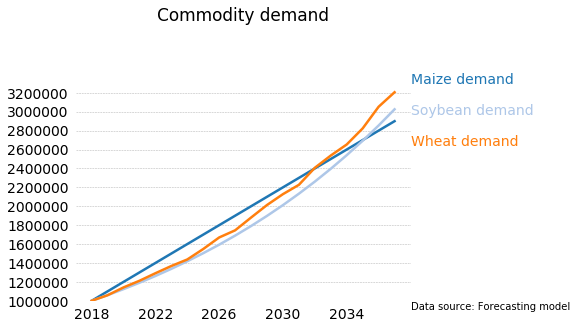

In [5]:
# Simulation parameters
start_year        = 2018   # start year of simulation
simulation_window = 20     # forecast 20 years
end_year          = start_year + simulation_window - 1
operational_hours = 4680   # operational hours per year
allowable_occupancy = 0.40

# Run scenario generator
vessels, commodities = scenario_generator(start_year, simulation_window)

# Import existing terminal infrastructure 
terminal = initial.terminal()

# Run simulation
terminal = simulate(terminal, allowable_occupancy, vessels, commodities, start_year, simulation_window)

# 4 Preliminary Plots

### Demand vs. Capacity

In [14]:
# Plotting capacity vs. demand 
#visualisation.throughput(terminal, 9,6)

In [16]:
#visualisation.revenue_capex_opex(terminal)

### Profit / Loss (nominal)

In [20]:
# Plotting annualised profits
#visualisation.profit_loss(terminal)

### Profit / Loss (present value)

In [19]:
# Plotting annualised profits
#visualisation.profit_loss_pv(terminal)

### Number of assets throughout the years

In [18]:
#visualisation.asset_trajectory(terminal, simulation_window, start_year)

# 5 Iterate through invest decisions

In [11]:
# Run multiple simulations, each with a different allowable berth occupancy between 20% and 95%
iterations = []

occupancy_spectrum = range (20, 96, 1)
for occupancy in occupancy_spectrum:
    
    # The trigger occupancy
    trigger_occupancy = occupancy/100
    
    # Load the initial terminal setup
    terminal = initial.terminal()
    
    # Run simulation
    terminal = simulate(terminal, trigger_occupancy, vessels, commodities, start_year, simulation_window)
    terminal.trigger = occupancy
    
    # Save resulting terminal 
    iterations.append(terminal)

In [17]:
# Visualise NPV distribution 
# visualisation.NPV_distribution(iterations)